In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Import Data

In [16]:
import pandas as pd
import numpy as np

# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=1000000)

businesses = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=1000000)

# Rename to distinguish star ratings after join
reviews = reviews.rename(columns={'stars': 'review_rating'})
businesses = businesses.rename(columns={'stars': 'business_rating'})
businesses['location'] = businesses['city'] + ", " + businesses['state']


# Data Pre-processing

In [17]:
# Filter businesses out (review_count < 20 and null business_id & review_count)
businesses =  businesses[businesses.review_count > 20]

# Remove all business with no business_id, review_count, and business_rating
businesses = businesses.dropna(subset=[
  'business_id', 'review_count', 'business_rating'
])

In [41]:
# Merge the business and reviews together 
all_reviews = pd.merge(reviews,businesses, on='business_id') 

print(all_reviews.columns)
print(all_reviews.shape)
# all_reviews.head()

Index(['review_id', 'user_id', 'business_id', 'review_rating', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_rating',
       'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'location'],
      dtype='object')
(881167, 23)


In [42]:
# Input features : Text, Location, Review_count
# Ouput (Predicted) feature : Business_rating
all_reviews = all_reviews[[
  'business_id', 
  'text', 
  # 'location', 
  'review_count',
  'business_rating', 
]]

# all_reviews.shape 
# Combine all the business's reviews into one text
business_reviews = all_reviews.groupby('business_id')['text'].sum()


# removes duplicates where the subsets are the same
all_reviews = all_reviews.drop_duplicates(subset=['business_id', 'business_rating', 'review_count'])

print(
  all_reviews.shape, business_reviews.shape
)

(11520, 4) (11520,)


In [62]:
# Create Dataframe with location, review_count, and business_rating
df_business_reviews = pd.DataFrame({
  # 'location' : all_reviews['location'],
  'review_count' : all_reviews['review_count'],
  'business_rating' : all_reviews['business_rating'],
})

# Create Dataframe for review text for TF IDF vectorizer 
text = pd.DataFrame({'text': business_reviews.values})

print(
  df_business_reviews.shape, text.shape
)

(11520, 2) (11520, 1)


In [63]:
# One hot encoding for location
# df_encoded = pd.get_dummies(df_business_reviews['location'])
# df_business_reviews = pd.concat([df_encoded, df_business_reviews], axis=1)

# Drop location column now that one)
# df_business_reviews.drop(['location'], axis=1, inplace=True)


# Replace nulls with mean and normalize review count for the business
missing_median(df_business_reviews, 'review_count')
encode_numeric_zscore(df_business_reviews, 'review_count')

print(df_business_reviews.shape)
print(df_business_reviews.columns)

(11520, 2)
Index(['review_count', 'business_rating'], dtype='object')


# TF_IDF Vectorizer

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(text['text'])

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

print(
  df_tfidfvect.shape, df_business_reviews.shape
)


(11520, 1000) (11520, 2)


# Create one table with all information

In [58]:
# business_id, rating concatonated onto the df_idfvect
print("Before: ", df_business_reviews.shape, df_tfidfvect.shape)

df_business_reviews.reset_index(drop=True, inplace=True)
df_tfidfvect.reset_index(drop=True, inplace=True)
df_business = pd.concat([df_business_reviews, df_tfidfvect], axis=1)


# df_business.fillna(value, inplace=True)
print(df_business.isna().sum())
print("After: ", df_business_reviews.shape, df_tfidfvect.shape)


Before:  (11520, 1) (11520, 1000)
business_rating    0
00                 0
10                 0
100                0
11                 0
                  ..
yelp               0
yes                0
young              0
yum                0
yummy              0
Length: 1001, dtype: int64
After:  (11520, 1) (11520, 1000)


# Test/Train Split

In [59]:
from sklearn.model_selection import train_test_split

x, y = to_xy(df_business, 'business_rating')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9216, 1000) (9216,) (2304, 1000) (2304,)


# Model Training

In [60]:
# Imports for all the models
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD, legacy

Epoch 1/100
288/288 - 6s - loss: 1.0418 - val_loss: 0.8488 - 6s/epoch - 21ms/step
Epoch 2/100
288/288 - 4s - loss: 0.7628 - val_loss: 0.7446 - 4s/epoch - 15ms/step
Epoch 3/100
288/288 - 4s - loss: 0.7340 - val_loss: 0.7501 - 4s/epoch - 12ms/step
Epoch 4/100
288/288 - 3s - loss: 0.7231 - val_loss: 0.7122 - 3s/epoch - 11ms/step
Epoch 5/100
288/288 - 4s - loss: 0.7150 - val_loss: 0.7351 - 4s/epoch - 13ms/step
Epoch 6/100
288/288 - 3s - loss: 0.7050 - val_loss: 0.7406 - 3s/epoch - 11ms/step
Epoch 6: early stopping
72/72 [==============================] - 0s 5ms/step
Score (RMSE): 0.8438947796821594


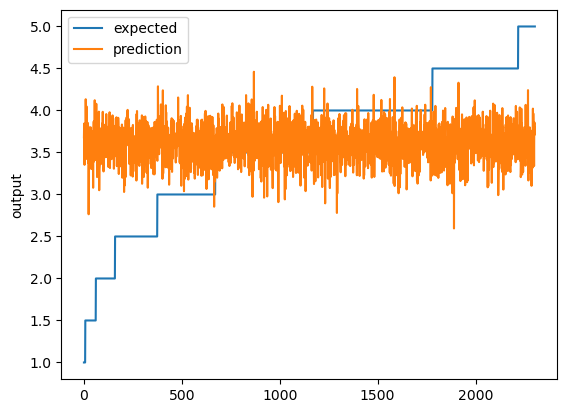

In [61]:
# Model # 1
# NO Location, No Review_count, Only text features # = 1000

parameters = {
  'learning_rate' : 0.001, 
  'batch_size' : 32, 
  'epochs' : 100
}

# Initialize Optimizers
adam = optimizers.Adam(learning_rate=parameters['learning_rate'], beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(learning_rate=parameters['learning_rate'], momentum=0.9, nesterov=True)  

# Initialize ModelCheckpoint and EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.keras", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(1000, input_dim=x.shape[1]))
model.add(Dense(512))
model.add(Dense(100))
model.add(Dense(1))

# model = Sequential()
# model.add(Dense(64, input_dim=x.shape[1], activation='tanh'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)


model.fit(
  x_train,y_train,validation_data=(x_test,y_test), 
  batch_size= parameters['batch_size'], callbacks=[monitor, checkpointer],
  verbose=2,epochs=parameters['epochs']
)

model.load_weights('dnn/best_weights1.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

In [ ]:
# Model # 2 : Optimizer Adam, 2 Small Hidden Layers, Activation Function (tanh)

parameters = {
  'learning_rate' : 0.001, 
  'batch_size' : 32, 
  'epochs' : 100
}

# Initialize Optimizers
adam = optimizers.Adam(learning_rate=parameters['learning_rate'], beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(learning_rate=parameters['learning_rate'], momentum=0.9, nesterov=True)  

# Initialize ModelCheckpoint and EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.keras", verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(1000, input_dim=x.shape[1]))
# model.add(Dense(512))
# model.add(Dense(100))
model.add(Dense(1))

# model = Sequential()
# model.add(Dense(64, input_dim=x.shape[1], activation='tanh'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=sgd)


model.fit(
  x_train,y_train,validation_data=(x_test,y_test), 
  batch_size= parameters['batch_size'], callbacks=[monitor, checkpointer],
  verbose=2,epochs=parameters['epochs']
)

model.load_weights('dnn/best_weights1.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

In [34]:
# Model # 2 : 
# Optimizer SGD, 3 hidden layers with more neurons, Activation Func (Tanh, Relu)
# Decreased Batch Size and Learning Rate

parameters = {
  'learning_rate' : 1e-5, 
  'batch_size' : 8, 
  'epochs' : 20
}

# Initialize Optimizers
sgd = optimizers.SGD(learning_rate=parameters['learning_rate'], momentum=0.9, nesterov=True)  
adam = legacy.Adam(learning_rate=parameters['learning_rate'])


# Initialize ModelCheckpoint and EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=2, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights2.keras", verbose=0, save_best_only=True)

# model = Sequential()
# model.add(Dense(512, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(256, activation='relu'))
# # model.add(Dense(128, activation='relu'))
# model.add(Dense(1))

model = Sequential()
model.add(Dense(1024, activation='tanh'))
model.add(Dense(2058, activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=sgd)

model.fit(
  x_train,y_train,validation_data=(x_test,y_test), 
  batch_size= parameters['batch_size'], callbacks=[monitor, checkpointer],
  verbose=2,epochs=parameters['epochs']
)
model.load_weights('dnn/best_weights2.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)


Epoch 1/20
1152/1152 - 69s - loss: 7.3585 - val_loss: 1.6813 - 69s/epoch - 60ms/step
Epoch 2/20
1152/1152 - 65s - loss: 0.8498 - val_loss: 0.6683 - 65s/epoch - 56ms/step
Epoch 3/20
1152/1152 - 65s - loss: 0.6889 - val_loss: 0.6660 - 65s/epoch - 56ms/step
Epoch 4/20
1152/1152 - 65s - loss: 0.6859 - val_loss: 0.6637 - 65s/epoch - 57ms/step
Epoch 5/20
1152/1152 - 68s - loss: 0.6833 - val_loss: 0.6607 - 68s/epoch - 59ms/step
Epoch 6/20
1152/1152 - 65s - loss: 0.6816 - val_loss: 0.6586 - 65s/epoch - 56ms/step
Epoch 7/20
1152/1152 - 66s - loss: 0.6797 - val_loss: 0.6574 - 66s/epoch - 57ms/step
Epoch 8/20


KeyboardInterrupt: 

Epoch 1/20
285/285 - 16s - loss: 12.2608 - val_loss: 10.7182 - 16s/epoch - 56ms/step
Epoch 2/20
285/285 - 15s - loss: 9.0070 - val_loss: 7.4380 - 15s/epoch - 53ms/step
Epoch 3/20
285/285 - 15s - loss: 5.8313 - val_loss: 4.3856 - 15s/epoch - 51ms/step
Epoch 4/20
285/285 - 14s - loss: 3.1557 - val_loss: 2.1275 - 14s/epoch - 51ms/step
Epoch 5/20
285/285 - 14s - loss: 1.4950 - val_loss: 1.0079 - 14s/epoch - 50ms/step
Epoch 6/20
285/285 - 14s - loss: 0.8352 - val_loss: 0.6634 - 14s/epoch - 50ms/step
Epoch 7/20
285/285 - 14s - loss: 0.6656 - val_loss: 0.5877 - 14s/epoch - 50ms/step
Epoch 8/20
285/285 - 14s - loss: 0.6324 - val_loss: 0.5724 - 14s/epoch - 50ms/step
Epoch 9/20
285/285 - 15s - loss: 0.6249 - val_loss: 0.5686 - 15s/epoch - 51ms/step
Epoch 10/20
285/285 - 14s - loss: 0.6222 - val_loss: 0.5673 - 14s/epoch - 51ms/step
Epoch 11/20
285/285 - 14s - loss: 0.6203 - val_loss: 0.5667 - 14s/epoch - 51ms/step
Epoch 12/20
285/285 - 14s - loss: 0.6187 - val_loss: 0.5663 - 14s/epoch - 50ms/step

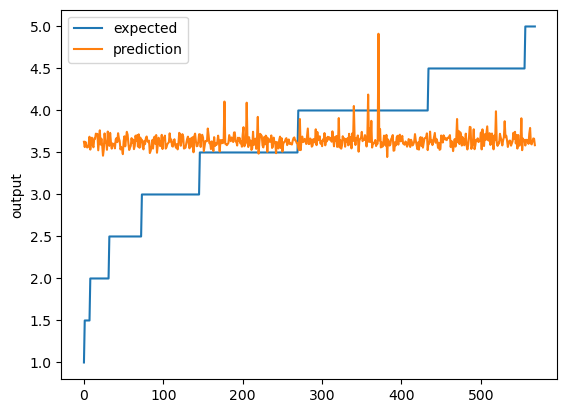

In [15]:
# Model #1 : (decide # of neurons in hiddens layers, relu, adam)
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import InputLayer

parameters = {
  'learning_rate' : 1e-5,
  'batch_size' : 8,
  'epochs' : 20
}

model = Sequential()
# model.add(Dense(64, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1024, activation='relu'))

model.add(Dense(2048, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(1))

adam = optimizers.Adam(learning_rate=parameters['learning_rate'], beta_1=0.9, beta_2=0.999)
# adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
sgd = optimizers.SGD(learning_rate=parameters['learning_rate'], momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(loss='mean_squared_error', optimizer=sgd)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.keras", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= parameters['batch_size'], callbacks=[monitor, checkpointer],verbose=2,epochs=parameters['epochs'])
model.load_weights('dnn/best_weights.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)